In [1]:
import numpy as np
from importlib import reload
from scipy import signal

import plotting_tools as pt
import utils
import dsi
utils = reload(utils)
pt = reload(pt)
dsi = reload(dsi)

import dill as pickle
import sys
import os
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib import rc

# activate latex text rendering
rc('text', usetex=True)

In [2]:
i2 = (slice(2,-2),slice(2,-2))

def load(Nx,Ny,et,test):
    if test == 'mark':
        base_fn = 'output_mark_wave'
    elif test == 'lamb':
        base_fn = 'output_lamb_wave'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et)
    tags = tc.get_tag_dict()
    
    return tc, tags

def get_ens(tc, times, sfx , diff, attribute, tag, NIDX):
    idx = 0 if tag == 'ic' else -1
    times = [0] if tag == 'ic' else times
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=False,load_ic=True)[idx]

    label = sfx + '_' + attribute
    return label, ens.T[:NIDX,:]

def get_ens_all(tc, times, sfx , diff, attribute, tag, NIDX):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type=l_typ, avg=True, diff=diff, tag=tag, inner=True,load_ic=True)
    ens = ens[:,:,:NIDX]
#     print(ens.shape)
    return ens

def get_arr(typ, times, NIDX, tp='half', test='mark', et=8000.0):
    sfx1 = '%s' %typ
#     if ib: sfx1 = '%s_ib-0' %sfx1
#     print(sfx1, typ)

    tc, tags = load(Nx,Ny,et,test)
    if tp=='afs':
        tag = 'after_full_step'
    else:
        tag = tp

    # load pickled instances of data used in simulation
    fn_pickle = tc.get_filename(N,sfx1,format='dat')
    path_pickle = tc.get_path(fn_pickle)

#     print(path_pickle)
    file = open(path_pickle,'rb')
    ud = pickle.load(file)
    mpv = pickle.load(file)
    dap = pickle.load(file)
    elem = pickle.load(file)
    file.close()

    S0 = (ud.stratification(elem.y)).reshape(-1,1)[:NIDX]
    
#     attributes = ['rhoX','rhou', 'rhov', 'rhoY', 'p2_nodes']
    attributes = ['rhov', 'rhoY', 'p2_nodes']
    _, rho = get_ens(tc, times, sfx1, diff, 'rho', tag, NIDX)
    la = r''
    ret = []
    
    _, rhou = get_ens(tc, times, sfx1, diff, 'rhou', tag, NIDX)
    u = rhou / rho
    u = u[i2]
    ret.append([u, r' $u^\prime$'])
    
    for attribute in attributes:
        _, aa = get_ens(tc, times, sfx1, diff, attribute, tag, NIDX)
        if attribute == 'rhoY':
            la_curr = la + r' $\Theta^\prime$'
        elif attribute == 'rhov':
            la_curr = la + r' $w^\prime$'
        elif attribute == 'rhou':
            la_curr = la + r' $u^\prime$'
        elif attribute == 'rhoX':
            la_curr = la + r' $\chi^\prime$'
        else:
            la_curr = la + r' $\pi^\prime$'
        
        if attribute == 'rhoY':
            aa = aa / rho
            aa -= S0
            aa = aa[i2]
        elif attribute == 'rhou':
            aa = aa / rho
            aa = aa[i2]
        elif attribute == 'rhov':
            aa = aa / rho
            aa = aa[i2]
        elif attribute == 'rhoX':
            aa = aa / rho
            aa = aa[i2]
        elif attribute == 'p2_nodes':
            aa = aa[i2]
            
        ret.append([aa,la_curr])
    
    return np.array(ret), (ud,mpv), tc

In [30]:
l_typ = 'WINDOW_STEP'
diff = False
attr_labels = pt.labels()

tp ='afs'
tag = 'after_full_step'
time_unit = 's'
N = 1

times0 = np.arange(31)

Nxs = [301]
Nys = [120]
Nts = [200,400,600,800,1000,1200]
Nts = [600]
oms = ['', '_noom']

lu = np.arange(-0.004/2,0.004/2+0.0005,0.0005)
lv = np.arange(-0.0008/2,0.0008/2+0.0001,0.0001)
lrhoY = np.arange(-0.0006/2,0.0006/2+0.000075,0.000075)
lp2n = np.arange(-0.001,0.00125,0.00025)
lvls = [lu,lv,lrhoY,lp2n]

for Nx, Ny in zip(Nxs,Nys):
    NIDX = int(Ny/4+4)
#     print('NIDX = %i' %NIDX)
    
    for Nt in Nts:
        for om in oms:
            typ1 = 'bdl_run_S%i%s_a05' %(Nt,om)
            _,ics,tc = get_arr(typ1,times0, NIDX, tp=tp, et=720.0)
            
            ud, mpv = ics[0], ics[1]
            _ = get_ens_all(tc, times0, typ1, False, 'rho', tag, NIDX)[:]

            t_axs = np.append(0,times0)
            phys_time = tc.t_arr

            if '_noom_' in typ1:
                tcase = 'wo_omega'
                tstr = r'0.0'
                fld = 'noom'
            else:
                tcase = 'a05'
                tstr = '%.6f' %(ud.coriolis_strength[2] / ud.t_ref)
                fld = 'om'

            for idx,time in enumerate(times0):
                tp = 'ic' if time == 0 else 'afs'
                aa2,ics,_ = get_arr(typ1,[time], NIDX, tp=tp, et=720.0)
                ud, mpv = ics[0], ics[1]
                ct = 0.0 if time == 0 else time

                pl_lst = aa2
                pl = pt.plotter(pl_lst,ncols=2,figsize=(32,20),sharey=False, fontsize=32)
                x_axs = np.array(np.linspace(ud.xmin,ud.xmax,7))
                y_axs = np.array(np.linspace(ud.ymin,ud.ymax,6))

                x_axs = np.around(x_axs,3)
                y_axs = np.around(y_axs/4,1)

                x_loc = np.linspace(0,Nx-1,7)
                y_loc = np.linspace(0,Ny/4-1,6)

                x_label = r'x [$\times 10$ km]'
                y_label = r'y [$\times 10$ km]'

                pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)

                tu = ud.t_ref#/3600
                stitle = r'$\Omega_y = %s s^{-1}$, time-step = %i, time = %.2f %s' %(tstr, idx, phys_time[idx]*tu, time_unit)
                _ = pl.plot(method='contour', lvls=lvls, suptitle=stitle, rect=[0, 0.03, 1, 0.95])

                fld_pth = './output_mark/%ix%i/S%i/%s' %(Nx,Ny,Nt,fld)
                if not os.path.exists(fld_pth):
                    os.makedirs(fld_pth)
                    
                pl.save_fig('%s/lamb_%s_%.3d' %(fld_pth, tcase,ct), format='.png')
                plt.close()

bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/ray/git-projects/RKLM_Reference/visualiser_debugger/plotting_tools.py:168: UserWarning: No contour levels were found within the data range.
  im = cax.contour(arr,linewidths=1.0,colors='k',levels=lvls)


(32, 301, 34)
bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat
bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat
bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat
bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat
bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat
bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat
bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat
bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat
bdl_run_S6

/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_a05 bdl_run_S600_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(32, 301, 34)
bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/git-projects/RKLM_Reference/visualiser_debugger/plotting_tools.py:168: UserWarning: No contour levels were found within the data range.
  im = cax.contour(arr,linewidths=1.0,colors='k',levels=lvls)


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat
bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


bdl_run_S600_noom_a05 bdl_run_S600_noom_a05
../output_mark_wave/output_mark_wave_ensemble=1_301_120_720.000000_bdl_run_S600_noom_a05.dat


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [3]:
def get_norm(typ, times, NIDX):
    _,ics,tc = get_arr(typ,times, NIDX, tp=tp, et=720.0)
    ud, mpv = ics
    tt = times
    
    rhos = get_ens_all(tc, tt, typ, False, 'rho', tag, NIDX)[:]
    arrs_rhou = get_ens_all(tc, tt, typ, False, attribute, tag, NIDX)[:]
    arrs_rhov = get_ens_all(tc, tt, typ, False, 'rhov', tag, NIDX)[:]
    arrs_rhoY = get_ens_all(tc, tt, typ, False, 'rhoY', tag, NIDX)[:]
    arrs_pi = get_ens_all(tc, tt, typ, False, 'p2_nodes', tag, NIDX+1)[:]

    rhobar = mpv.HydroState.rho0[:NIDX]#[2:-2]
    uhat = arrs_rhou / rhos * rhobar**0.5 * (ud.u_ref * np.sqrt(ud.rho_ref))
    vhat = arrs_rhov / rhos * rhobar**0.5 * (ud.u_ref * np.sqrt(ud.rho_ref))
    Nfq = ud.Nsq_ref**0.5
    g = ud.gravity_strength[1] * ud.u_ref / ud.t_ref
    Ybar = mpv.HydroState.Y0[:NIDX]#[2:-2]
    Yhat = g / Nfq * (rhobar**0.5 * np.sqrt(ud.rho_ref)) / Ybar * (arrs_rhoY / rhos - Ybar)
    p2c = np.array([signal.fftconvolve(mem,[[1,1],[1,1]], mode='valid')/4.0 for mem in arrs_pi])
    C = (ud.u_ref * np.sqrt(1.4/ud.Msq))
    p2hat = 1.0 / C * (rhobar**0.5 * np.sqrt(ud.rho_ref)) * Ybar * p2c * ud.T_ref #* ud.Msq

    t_axs = np.array(tc.t_arr)
    tt = t_axs * ud.t_ref

    res = []
    for idx, arr in enumerate(arrs_rhou):
        u = uhat[idx]
        v = vhat[idx]
        Y = Yhat[idx]
        p = p2hat[idx]
        nnorm = np.array([u,v,Y,p])
        res.append(0.5*la.norm(nnorm)**2)

    res = np.array(res)
    
    return res, ud, tt

/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


3


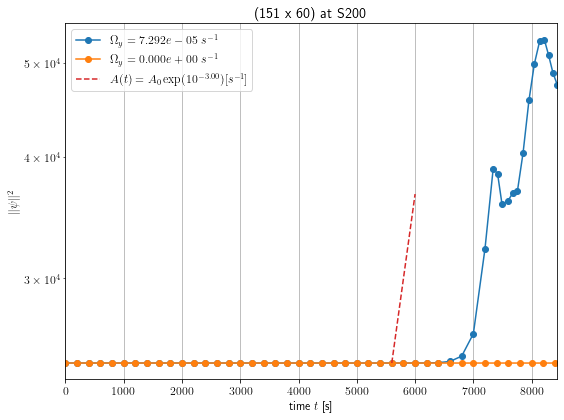

151 60 200


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


3


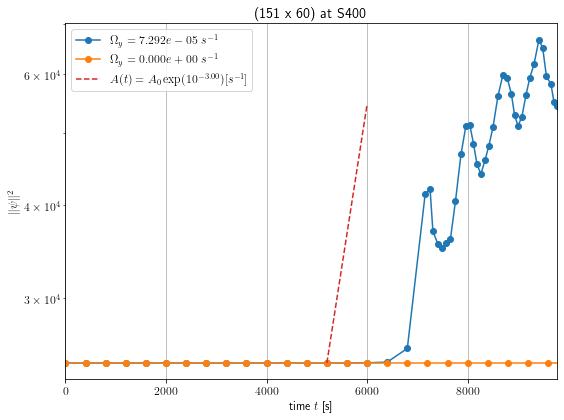

151 60 400


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2


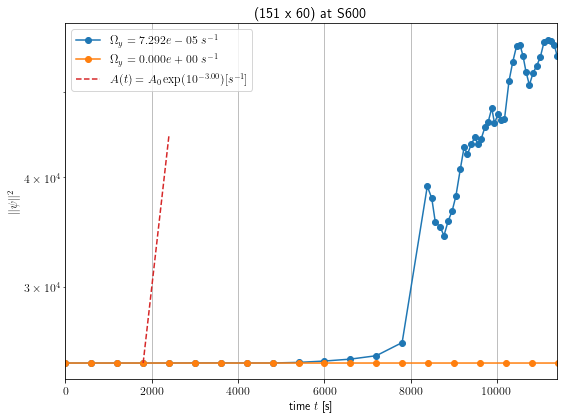

151 60 600


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2


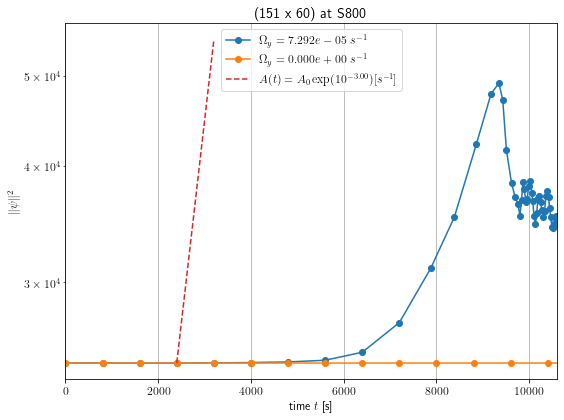

151 60 800


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2


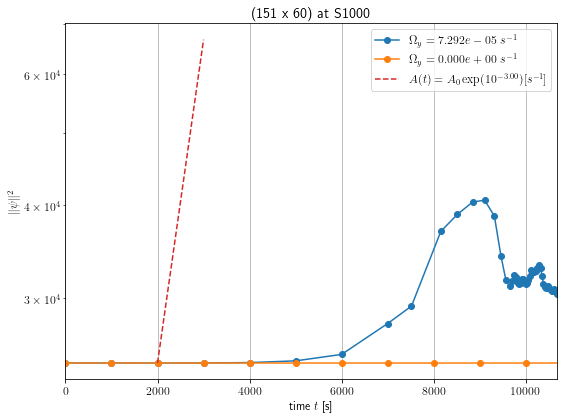

151 60 1000


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2


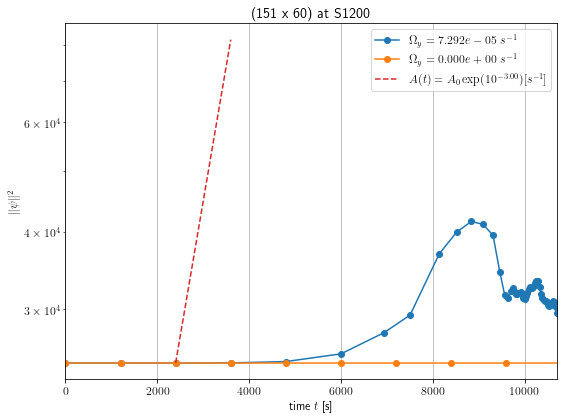

151 60 1200


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


3


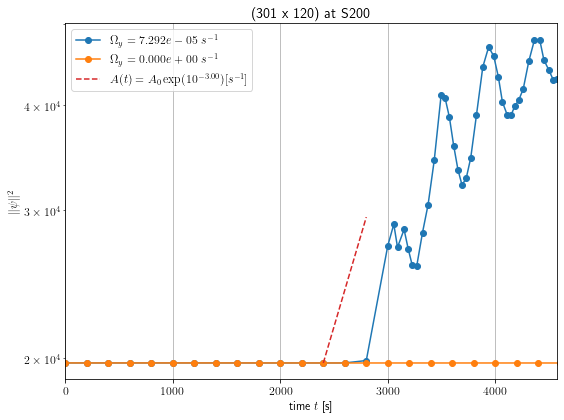

301 120 200


/home/ray/anaconda3/envs/playground/lib/python3.7/site-packages/ipykernel_launcher.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


3


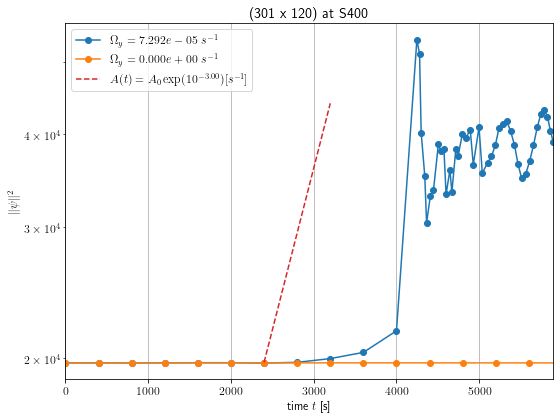

301 120 400


In [ ]:
from matplotlib.ticker import (FixedLocator)
from matplotlib import ticker
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

from numpy import linalg as la

l_typ = 'WINDOW_STEP'
diff = False

attr_labels = pt.labels()

Nxs = [151,301,601,1201]
Nys = [60,120,240,600]
Nts = [200,400,600,800,1000,1200]

N = 1
et = 720.0
nts = 50
times0 = np.arange(nts)

tp = 'afs'
attribute = 'rhou'
tag = 'after_full_step'

for Nx, Ny in zip(Nxs,Nys):
    for Nt in Nts:
        typ1 = 'bdl_run_S%i_a05' %Nt
        typ2 = 'bdl_run_S%i_noom_a05' %Nt
        NIDX = int(Ny/4+4)

        res_om, ud_om, tt_om = get_norm(typ1, times0, NIDX)
        res_noom, ud_noom, tt_noom = get_norm(typ2, times0, NIDX)

        fig = plt.figure(figsize=(8,6))
        fig.add_subplot(111)
        ax = plt.gca()

        tu_om = ud_om.t_ref
        tu_noom = ud_noom.t_ref
        ax.semilogy(tt_om, res_om, '-o', label=r'$\Omega_y = %.3e~s^{-1}$' %(ud_om.coriolis_strength[2] / tu_om / 2.0))
        ax.semilogy(tt_noom, res_noom, '-o', label=r'$\Omega_y = %.3e~s^{-1}$' %(ud_noom.coriolis_strength[2] / tu_noom / 2.0))

        nexp = 3.0
        def fth(t):
            return (res_om[res_om.argmin()+1].min()*np.exp(10**(-nexp)*t))

        tty = fth(tt_om)
        tt = np.copy(tt_om)
        tt += (tt_om)[np.argmin(res_om)]
        lls = 3
        while max(tty[:lls]) > max(res_om):
            if lls == 2: break
            lls -= 1
        while (0.5 * np.log10(max(res_om))) > max(tty[:lls]):
            lls += 1
        print(lls)
        tty = tty[:lls]
        tt = tt[:lls]

        ax.semilogy(tt, tty, 'C3--', label=r'$A(t) = A_0 \exp(10^{-%.2f})[s^{-1}]$' %nexp)

        formatter = ticker.ScalarFormatter()
        formatter.set_scientific(True) 
        formatter.set_powerlimits((-1,1)) 
        ax.yaxis.set_major_formatter(formatter)

        ymin, ymax = plt.gca().get_ylim()

        ax.set_ylabel(r'$\Vert \psi \Vert^2$')
        t_units = 's'
        ax.set_xlabel("time $t$ [%s]" %t_units)
        ax.set_title("(%i x %i) at S%i" %(Nx,Ny,Nt))
        ax.grid()
        ax.legend()
        plt.tight_layout()
        ax.set_xlim([0.0,tt_om.max()])
        fld_pth = './output_mark/%ix%i/S%i' %(Nx,Ny,Nt)
        if not os.path.exists(fld_pth):
            os.makedirs(fld_pth)
        plt.savefig('./output_mark/%ix%i/S%i/plot.pdf' %(Nx,Ny,Nt))
        plt.show()
#         plt.()

        print(Nx,Ny,Nt)